In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import pygad

import HydroErr

c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
EPOCHS = 500
TRAIN_YEAR = 19
PATIENCE = 20

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/final_lstm_embedding2.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder2.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# dtrain = dataloader.Forcing_Data(
#     "camels_train.csv",
#     record_length=2922,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

# dval = dataloader.Forcing_Data(
#     "camels_val.csv",
#     record_length=1095,
#     storge_device=storge_device,
#     seq_length=SEQ_LENGTH,
#     target_seq_length=TARGET_SEQ_LENGTH,
#     base_length=BASE_LENGTH,
# )

dtest = dataloader.Forcing_Data(
    "data/camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

In [5]:
class Objective_builder:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x.contiguous()
        self.y = y.contiguous()
    
    def eval(self, code, return_summary = True):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(computing_device)
        code = code.expand(self.x.shape[0], -1)
        
        # BASE_LENGTH is from global
        pred = decoder.decode(code, self.x).view(-1).detach().cpu().numpy()

        ob = self.y.view(-1).detach().cpu().numpy()
        
        if return_summary:
          gof = self.eval_fun(simulated_array=pred, observed_array=ob)
          return gof
        else:
          return pred, ob

In [6]:
num_generations = 200
num_parents_mating = 10

sol_per_pop = 100
num_genes = LATENT_dim

init_range_low = catchment_embeddings.detach().cpu().min().numpy().tolist()
init_range_high = catchment_embeddings.detach().cpu().max().numpy().tolist()

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25

x_batch_train_val, y_batch_train_val = dtrain_val.get_val_batch()
x_batch_test, y_batch_test = dtest.get_val_batch()

def evaluate_calibration(selected_catchment=0):
    
    x = x_batch_train_val[:,selected_catchment,:,:]
    y = y_batch_train_val[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    def fitness_func(ga_instance, solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability,
                        stop_criteria=["saturate_10"])

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    x = x_batch_test[:,selected_catchment,:,:]
    y = y_batch_test[:,selected_catchment,:]

    x, y = x.to(computing_device), y.to(computing_device)

    fn = Objective_builder(x,y,HydroErr.kge_2009)

    return fn.eval(solution), solution

In [7]:
N_CATCHMENTS = 559
calibrated_KGES = np.ones(N_CATCHMENTS)
camels_embeddings = np.ones([N_CATCHMENTS, LATENT_dim])

for i in range(N_CATCHMENTS):
    print(f'i={i} starts')
    calibrated_KGES[i], camels_embeddings[i,:]  = evaluate_calibration(i)
    print(f'fit={calibrated_KGES[i]}')

i=0 starts


c:\Users\User\Anaconda3\envs\pytorch2\Lib\site-packages\HydroErr\HydroErr.py:6248: UserWarning: Row(s) [3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297 3298 3299 3300
 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311 3312 3313 3314
 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325 3326 3327 3328
 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339 3340 3341 3342
 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353 3354 3355 3356
 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367 3368 3369 3370
 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384
 3385 3386 3387 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398
 3399 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412
 3413 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423 3424 3425 3426
 3427 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440
 3441 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454
 3455 3456 3457 3458 3459 3460 3461 3462 3463

fit=0.8912936780968745
i=1 starts
fit=0.8823883546151197
i=2 starts
fit=0.8591966099423587
i=3 starts
fit=0.8969882666394903
i=4 starts


In [8]:
np.savetxt("data/ga_KGEs.csv", calibrated_KGES, delimiter=",")
np.savetxt("data/ga_camels_embeddings.csv", camels_embeddings, delimiter=",")

# Result check

In [14]:
calibrated_KGES

array([ 0.91941096,  0.85682169,  0.91637485,  0.88217712,  0.88228154,
        0.88692423,  0.74929147,  0.78510157,  0.86397878,  0.84344607,
        0.76471023,  0.83853438,  0.83633127,  0.78910078,  0.84521933,
        0.81248433,  0.80268453,  0.84948467,  0.74234173,  0.76419514,
        0.76399213,  0.83128169,  0.76749481,  0.7045009 ,  0.78371101,
        0.50837783,  0.77227529,  0.26538183,  0.57192447,  0.6664474 ,
        0.62655947,  0.76148306,  0.71783067,  0.76387803,  0.79151405,
        0.80246345,  0.75337292,  0.78052573,  0.83671804,  0.80459067,
        0.81376294,  0.4992642 ,  0.7323576 ,  0.54922338,  0.80322473,
        0.80011686,  0.86071515,  0.8383424 ,  0.77542572,  0.71476613,
        0.68841337,  0.77964997,  0.51909695,  0.58665682,  0.75903779,
        0.79007346,  0.70983101,  0.58668493,  0.79720012,  0.69344743,
        0.65657411,  0.58694882,  0.69307331,  0.72728967,  0.79509138,
        0.71894977,  0.75483379,  0.68432546,  0.55662402,  0.76

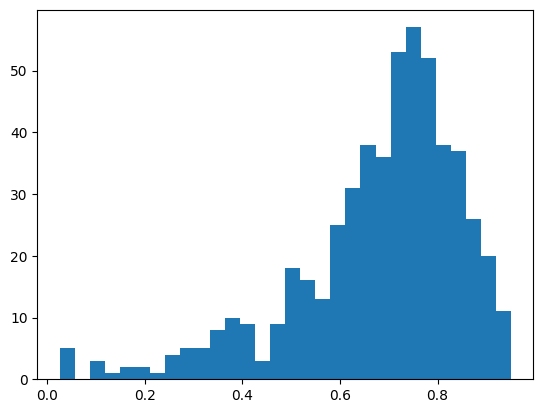

In [11]:
from matplotlib import pyplot as plt

plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [9]:
calibrated_KGES.mean()

0.6348132287213644

In [10]:
np.median(calibrated_KGES)

0.7147491069950322

In [12]:
calibrated_KGES

array([ 0.9420202 ,  0.86203084,  0.93148178,  0.78090595,  0.8144998 ,
        0.85943922,  0.7345685 ,  0.74645524,  0.87153836,  0.85908326,
        0.70320197,  0.82783057,  0.81370497,  0.75883473,  0.79800478,
        0.79103684,  0.69251102,  0.84624123,  0.74571939,  0.76050727,
        0.75696628,  0.79870878,  0.80228153,  0.61092393,  0.77352366,
        0.5178847 ,  0.75893902,  0.33690869,  0.5776642 ,  0.60836813,
        0.61926657,  0.75070486,  0.70483945,  0.75739337,  0.77527625,
        0.76888088,  0.73969803,  0.76075648,  0.71035561,  0.77706593,
        0.80669024,  0.45990407,  0.69342954,  0.51774221,  0.73530102,
        0.79113578,  0.82917616,  0.80798142,  0.69034885,  0.67988069,
        0.59830966,  0.73236492,  0.5081895 ,  0.54846339,  0.77213326,
        0.75237287,  0.71405785,  0.61706965,  0.75428625,  0.60311587,
        0.62767701,  0.56396525,  0.67107781,  0.72260505,  0.8072799 ,
        0.73522891,  0.72159259,  0.59516647,  0.3770068 ,  0.61